# Performance metrics of Buy & Hold Strategy

The purpose of this notebook is to calculate performance metrics over the benchmark and compare it with results obtained in other papers. I will compare my results with two papers:  
- Hybrid Investment Strategy Based on Momentum and Macroeconomic Approach - Kamil Korzeń, Robert Ślepaczuk  
- Predicting prices of S&P500 index using classical methods and recurrent neural networks - Mateusz Kijewski, Robert Ślepaczuk

In [1]:
# Settings for notebook visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline
from IPython.core.display import HTML
HTML("""<style>.output_png img {display: block;margin-left: auto;margin-right: auto;text-align: center;vertical-align: middle;} </style>""")

In [2]:
# Necessary imports
import os
import numpy as np
import pandas as pd
import matplotlib as plt
import quantstats as qs
print("Libraries imported correctly")

Libraries imported correctly


In [3]:
os.chdir("/Users/Sergio/Documents/Master_QF/Thesis/Code/Algorithmic Strategies")
%run Functions.ipynb

# Load data

Difference between Market_daily_ret and Market_daily_ret_with_fill is the return on the first day

In [4]:
%run Functions.ipynb
data = get_sp500_data(from_local_file=True, save_to_file=False)
data['Market_daily_ret_with_fill'] = data['Close'].pct_change()
data = data.loc['1991-01-03':'2020', ['Close', 'Market_daily_ret_with_fill']]
data.head()

,Close,Market_daily_ret_with_fill
Date,,
1991-01-03,321.910004,-0.013907
1991-01-04,321.000000,-0.002827
1991-01-07,315.440002,-0.017321
1991-01-08,314.899994,-0.001712
1991-01-09,311.489990,-0.010829


# Paper from Kamil: Hybrid Investment Strategy Based on Momentum and Macroeconomic Approach

Data from 1991-01-03 to 2018-01-03  
Uses daily returns to calculate the metrics

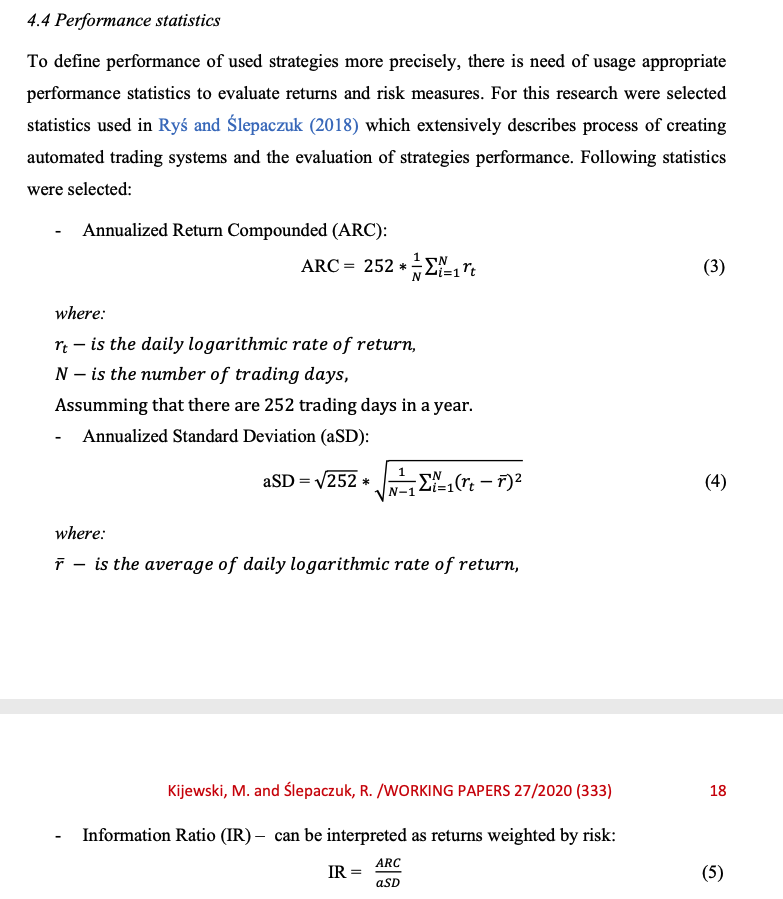

In [5]:
from IPython.display import Image
Image(filename='/Users/Sergio/Documents/Master_QF/Thesis/Papers/Performance metrics/K-Formulas.png')
# Data from 2000 : 2020-05-02

We prepare the columns

In [6]:
df_1 = data.loc['1991-01-03':'2018-01-03', ['Close', 'Market_daily_ret_with_fill']].copy()
ini_equity = data.loc['1991-01-02', 'Close'] # Initial equity is the Close price from previous year

df_1['Market_daily_ret'] = df_1['Close'].pct_change()
df_1['Market_cum_ret'] = df_1['Market_daily_ret'].add(1).cumprod().mul(df_1['Close'][0])
df_1['Market_cum_ret_with_fill'] = df_1['Market_daily_ret_with_fill'].add(1).cumprod().mul(ini_equity)

df_1 = df_1[['Close', 'Market_daily_ret', 'Market_daily_ret_with_fill', 'Market_cum_ret', 'Market_cum_ret_with_fill']]

df_1.head(4)
#df_1.tail(2)
#df_1['Close'].plot(title='SP500', legend=True)

KeyError: '1991-01-02'

We can see how 'Market_daily_ret' doesnt have a return on the first day.  
I believe I should use Market_daily_ret_with_fill, so we don´t ignore the return from the first day (which was -1.3907%).  
But in this paper, the return from the first day of 1991 was ignored, as we can see in the following cells.  
Could you confirm?

Metrics from paper:

In [ ]:
from IPython.display import Image
Image(filename='/Users/Sergio/Documents/Master_QF/Thesis/Papers/Performance metrics/K-Table.png')

In [ ]:
metrics = ['AbsRet', 'ARC', 'IR', 'aSD', 'MD']

paper_data = [[742.801, 8.222, 0.466, 17.652, 56.775]]
df_metrics = pd.DataFrame(data=paper_data, index=['Paper metrics'], columns=metrics).round(3)

df_metrics

Lets see how this empty cell affects performance metrics.  
Metrics calculated manually:

In [ ]:
n = len(df_1['Market_daily_ret'].dropna()) # This one excludes the first row
n_with_fill = len(df_1['Market_daily_ret_with_fill'])
print("n = {}\tn_with = {}\n".format(n, n_with_fill))

AbsRet_1 = (df_1['Market_daily_ret'].add(1).cumprod().sub(1)[-1]) * 100
AbsRet_2 = (df_1['Market_daily_ret_with_fill'].add(1).cumprod().sub(1)[-1]) * 100
AbsRet_3 = (df_1['Close'][-1]/df_1['Close'][0] - 1) * 100
print("AbsRet_1 = {}\tAbsRet_2 = {}\tAbsRet_3 = {}".format(AbsRet_1, AbsRet_2, AbsRet_3))
print("AbsRet_2 starts conting returns from the Close price of the previous day, so the result is slightly different (and the correct one?):\n"
    "What should we take as the initial price to calculate the Absolute Return? \n"
    "\t- Close price of first day of 1991 (AbsRet_1 and AbsRet_3)?\n"
    "\t- Close from last day of 1990 (AbsRet_3)?\n"
    "\t- Open price of first day of 1991?\n")

ARC_1 = ((df_1['Market_daily_ret'].add(1).cumprod()[-1])**(252/n) - 1) * 100
ARC_2 = ((df_1['Market_daily_ret_with_fill'].add(1).cumprod()[-1])**(252/n_with_fill) - 1) * 100
ARC_3 = ((df_1['Close'][-1]/df_1['Close'][0])**(252/n_with_fill) - 1) * 100
print("\nARC_1 = {}\tARC_2 = {}\nARC_3 = {}".format(ARC_1, ARC_2, ARC_3))
print("ARC has a similar situation as before. We have to decide what to do with:\n"
    "\t- daily returns (with/without the return from the first day)\n"
    "Which one should I use?\n")

aSD_1 = (df_1['Market_daily_ret'].var()**0.5) * (252**0.5) * 100 # Same as df_1['Market_daily_ret'].std() * (252**0.5) * 100
aSD_2 = (df_1['Market_daily_ret_with_fill'].var()**0.5) * (252**0.5) * 100
print("\naSD_1 = {}\taSD_2 = {}".format(aSD_1, aSD_2))
print("Here we have the same problem, though results are much more similar (because is the standard deviation)\n")

IR_1 = ARC_1/aSD_1
IR_2 = ARC_2/aSD_2
print("\nIR_1 = {}\tIR_2 = {}".format(IR_1, IR_2))
print("Again. ARC and aSD coming from 'Market_daily_ret' or 'Market_daily_ret_with_fill'\n")

MD_1 = abs(qs.stats.max_drawdown(df_1['Market_daily_ret'])) * 100
MD_2 = abs(qs.stats.max_drawdown(df_1['Market_daily_ret_with_fill'])) * 100
print("\nMD_1 = {}\tMD_2 = {}".format(MD_1, MD_2))
print("Again. Though that first day has no effect on the result\n")

without_fill_data = [[AbsRet_1, ARC_1, IR_1, aSD_1, MD_1]]
without_fill_row = pd.DataFrame(data=without_fill_data, index=['Without fill'], columns=metrics)

with_fill_data = [[AbsRet_2, ARC_2, IR_2, aSD_2, MD_2]]
with_fill_row = pd.DataFrame(data=with_fill_data, index=['With fill'], columns=metrics)

df_metrics = pd.concat([df_metrics, without_fill_row, with_fill_row], axis=0).drop_duplicates()
df_metrics

I think we should be taking into consideration return from the close of the previous day to our first day, but I would like an opinion about this.